# Predictive modeling of the risk of eclampsia in pregnancy using neural network approaches

## Dataset: Maternal Health Risk

### Licence of use

- That dataset was collected from UCI Machine Learning Repository -https://archive.ics.uci.edu/dataset/863/maternal+health+risk

- licence by Creative Commons Attribution 4.0 (CC BY 4.0) https://creativecommons.org/licenses/by/4.0/


# 1. Research understanding phase

- In this study, a comprehensive analysis of the risk of eclampsia during pregnancy was provided, with data collected by age, blood pressure, heart rate, blood sugar level and body temperature. 
- Data preparation, information extraction, modeling, training and data normalization were carried out to perform data classification. 
- The dataset was correctly loaded into Hadoop, being able to use the PySparkSQL and TensorFlow, using SQL and Python coding language. an Artificial Neural Network model was applied to the chosen variables X and y, as well as hyperparameters to decide the best model and obtain the models' accuracy.
- To achieve an organized and clear understanding of the study schedule, the Cross Industry Standard Process for Data Mining (CRISP-DM) methodology was used, and the code cells were grouped according to the phases of the methodology.

## About the dataset

- The Data has been collected from different hospitals, community clinics, maternal health cares from the rural areas of Bangladesh through the IoT based risk monitoring system.

###  Attributes Description:

- Age - Age in years when a woman is pregnant
- SystolicBP - Upper value of Blood Pressure in mmHg
- DiastolicBP - Lower value of Blood Pressure in mmHg
- BS - Blood glucose levels is in terms of a molar concentration, mmol/L
- BodyTemp - Body temperature in Fahrenheit
- HeartRate - Resting heart rate in beats per minute
- RiskLevel - Predicted Risk Intensity Level during pregnancy ['high risk', 'mid risk', 'low risk']

In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

# 2. Data Understanding Phase

### Practical Big Data (PySparkSQL) - Part 1

In [2]:
# Load the libraries
import os
import numpy as np
import pandas as pd
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.sql import functions as f
from pyspark.sql.functions import udf, StringType
from pyspark.sql import SparkSession, functions as F
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer

In [3]:
# Due the different version of python can be found and each machine or libriries 
# Avoid warnigs
import warnings
warnings.filterwarnings("ignore")

In [4]:
#Import PySparkSQL
import pyspark
from pyspark.sql import SparkSession

# Create SparkSession
spark = SparkSession.builder \
    .appName("Análise de Dados de Saúde Materna") \
    .getOrCreate()

In [5]:
# Path to dataset
csv_file = "/user/user1/Maternal_Health_Risk.csv"

# Read and create a temporary view
df = spark.read.format("csv") \
    .option("inferSchema", "true") \
    .option("header", "true") \
    .load(csv_file)
df.createOrReplaceTempView("rawdata")

In [6]:
# Visualise inferred schema
df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- SystolicBP: integer (nullable = true)
 |-- DiastolicBP: integer (nullable = true)
 |-- BS: double (nullable = true)
 |-- BodyTemp: double (nullable = true)
 |-- HeartRate: integer (nullable = true)
 |-- RiskLevel: string (nullable = true)



In [7]:
# Execute an SQL query to select the first 10 rows from the temporary view
data = spark.sql("SELECT * FROM rawdata LIMIT 10")

# Directly display the query results
data.show()

+---+----------+-----------+----+--------+---------+---------+
|Age|SystolicBP|DiastolicBP|  BS|BodyTemp|HeartRate|RiskLevel|
+---+----------+-----------+----+--------+---------+---------+
| 25|       130|         80|15.0|    98.0|       86|high risk|
| 35|       140|         90|13.0|    98.0|       70|high risk|
| 29|        90|         70| 8.0|   100.0|       80|high risk|
| 30|       140|         85| 7.0|    98.0|       70|high risk|
| 35|       120|         60| 6.1|    98.0|       76| low risk|
| 23|       140|         80|7.01|    98.0|       70|high risk|
| 23|       130|         70|7.01|    98.0|       78| mid risk|
| 35|        85|         60|11.0|   102.0|       86|high risk|
| 32|       120|         90| 6.9|    98.0|       70| mid risk|
| 42|       130|         80|18.0|    98.0|       70|high risk|
+---+----------+-----------+----+--------+---------+---------+



In [8]:
# Count rows
num_rows = spark.sql("SELECT COUNT(*) as TotalRows FROM rawdata").show()

# Count columns using the PySpark DataFrame (not directly SQL)
num_columns = len(df.columns)
print(f"Number of Columns: {num_columns}")

+---------+
|TotalRows|
+---------+
|     1014|
+---------+

Number of Columns: 7


### Missing values

In [9]:
from pyspark.sql.functions import col, sum as _sum, when

# Listing the number of missing values per column
df.select([_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns]).show()

+---+----------+-----------+---+--------+---------+---------+
|Age|SystolicBP|DiastolicBP| BS|BodyTemp|HeartRate|RiskLevel|
+---+----------+-----------+---+--------+---------+---------+
|  0|         0|          0|  0|       0|        0|        0|
+---+----------+-----------+---+--------+---------+---------+



In [10]:
# Collecting data for visualization
risk_level_distribution = spark.sql("SELECT RiskLevel, COUNT(*) as Count FROM rawdata GROUP BY RiskLevel").toPandas()

# Check the collected data
print(risk_level_distribution)

   RiskLevel  Count
0   low risk    406
1   mid risk    336
2  high risk    272


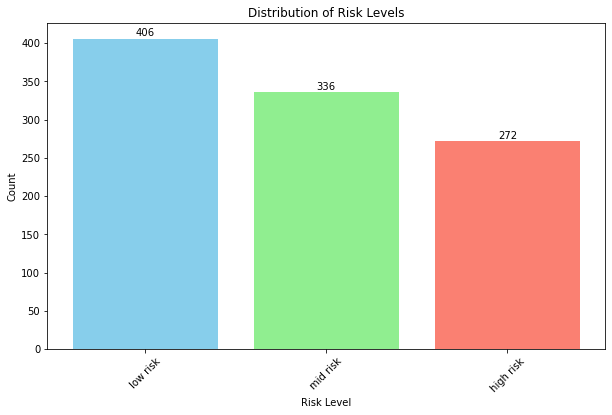

In [11]:
import matplotlib.pyplot as plt

# Plotting the distribution of Risk Levels with counts above bars
plt.figure(figsize=(10, 6))
bars = plt.bar(risk_level_distribution['RiskLevel'], risk_level_distribution['Count'], color=['skyblue', 'lightgreen', 'salmon'])

# Adding counts above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')

plt.title('Distribution of Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Comparative bar chart for average Systolic and Diastolic blood pressure, by Risk Level level.

In [12]:
# Determining the associations between the average systolic and diastolic blood pressures (SystolicBP and DiastolicBP, respectively) and the RiskLevel.
pressure_risk = spark.sql("""
SELECT 
    RiskLevel, 
    AVG(SystolicBP) AS AvgSystolicBP, 
    AVG(DiastolicBP) AS AvgDiastolicBP 
FROM rawdata 
GROUP BY RiskLevel
""").toPandas()

- The purpose of the query is to evaluate the data with an emphasis on determining the associations between the average systolic and diastolic blood pressures SystolicBP and DiastolicBP, respectively and the RiskLevel.

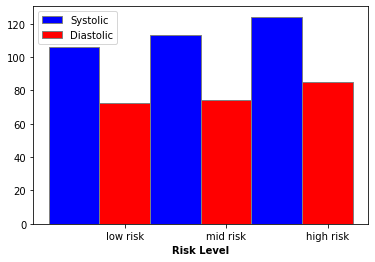

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Bar width
barWidth = 0.50

# Setting the position of the bars
r1 = np.arange(len(pressure_risk['RiskLevel']))
r2 = [x + barWidth for x in r1]

# Creating the bars
plt.bar(r1, pressure_risk['AvgSystolicBP'], color='blue', width=barWidth, edgecolor='grey', label='Systolic')
plt.bar(r2, pressure_risk['AvgDiastolicBP'], color='red', width=barWidth, edgecolor='grey', label='Diastolic')

# Adding labels to the bars
plt.xlabel('Risk Level', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(pressure_risk['RiskLevel']))], pressure_risk['RiskLevel'])

# Creating the legend and showing the plot
plt.legend()
plt.show()

### Average Age by Risk Level chart

In [14]:
age_risk = spark.sql("""
SELECT 
    RiskLevel, 
    AVG(Age) AS AvgAge 
FROM rawdata 
GROUP BY RiskLevel
ORDER BY CASE 
    WHEN RiskLevel = 'low risk' THEN 1
    WHEN RiskLevel = 'mid risk' THEN 2
    WHEN RiskLevel = 'high risk' THEN 3
    ELSE 4
END
""").toPandas()

- By analyzing how the average age varies between different risk levels, through this analysis it is possible to identify age-related patterns or trends that may be relevant to understanding risk.

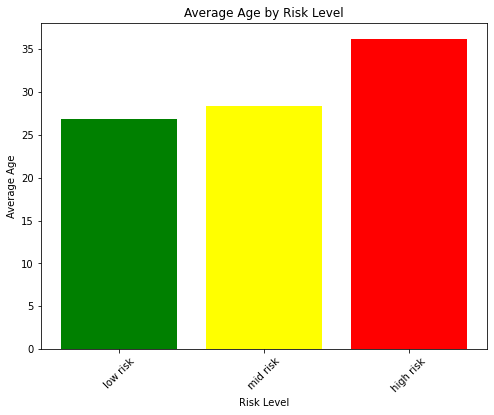

In [15]:
import matplotlib.pyplot as plt

# Adjusting color_mapping to match the exact strings from the SQL query
color_mapping = {
    'high risk': 'red',    # Matching 'high risk' to red
    'mid risk': 'yellow',  # Matching 'mid risk' to yellow
    'low risk': 'green'    # Matching 'low risk' to green
}

# Applying the color mapping to generate a list of colors for each bar
# This assumes age_risk['RiskLevel'] contains 'low risk', 'mid risk', 'high risk'
bar_colors = [color_mapping[risk_level] for risk_level in age_risk['RiskLevel']]

plt.figure(figsize=(8, 6))
plt.bar(age_risk['RiskLevel'], age_risk['AvgAge'], color=bar_colors)

# Adding titles and labels
plt.title('Average Age by Risk Level')
plt.xlabel('Risk Level')
plt.ylabel('Average Age')
plt.xticks(rotation=45)  # Rotating X-axis labels for better readability

# Displaying the chart
plt.show()

- This chart provides a clear visualization of how the average age varies between different risk levels. This can help identify whether there is an age trend associated with risk level.

# Modeling Phase

##  Neural Network For Binary Classification

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Determine the number of input features
n_features = X_train_scaled.shape[1]

# Create a sequential model
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(n_features,)))
model.add(Dense(8, activation='relu'))
# If RiskLevel is binary, use 1 output neuron with sigmoid, otherwise adjust for multiclass
model.add(Dense(1, activation='sigmoid'))  # Use 'softmax' and adjust the number of neurons if it's multiclass

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Adjust as necessary

NameError: name 'X_train_scaled' is not defined

In [ ]:
# Evaluating the model
history = model.fit(X_train_scaled, y_train, epochs=140, batch_size=32, validation_split=0.2, verbose=1)

In [ ]:
# Evaluating the model on the test set
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test set accuracy: {accuracy:.4f}')

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming X_train training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform training data

In [ ]:
# making a prediction
new_data = np.array([[42, 140, 85, 13, 98, 75]])  # Replace with actual values
new_data_scaled = scaler.transform(new_data)  # This should work if 'scaler' is defined and fitted correctly
prediction = model.predict(new_data_scaled)
print(f'Prediction: {prediction}')

In [ ]:
pip install keras-tuner

### Tuning hyperparameter

In [ ]:
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units_input', min_value=32, max_value=512, step=32), activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dense(hp.Int('units_hidden', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # Adjusting the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Maximum number of hyperparameter combinations to test
    executions_per_trial=2,  # Number of models to train and evaluate for each trial
    directory='tuner_results',
    project_name='keras_tuner_demo'
)

In [ ]:
tuner.search(X_train_scaled, y_train, epochs=20, validation_split=0.2, verbose=1)

#### Retrieving and evaluate the best model found by the hyperparameter tuning process using Keras Tuner

In [ ]:
# Best hyperparameter
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0]

# Evaluating the best model
loss, accuracy = best_model.evaluate(X_test_scaled, y_test)
print(f'Test set accuracy of the best model: {accuracy:.4f}')

print("Best hyperparameters:", best_hyperparameters.values)

### LTM Feedforward RNA

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col

# Index the label if it's categorical
indexer = StringIndexer(inputCol="RiskLevel", outputCol="label")
df = indexer.fit(df).transform(df)

# Assemble features into a single feature vector
assembler = VectorAssembler(inputCols=["Age", "SystolicBP", "DiastolicBP", "BS", "BodyTemp", "HeartRate"], outputCol="features")
data = assembler.transform(df)

# Splitting the data into training and test sets
train_data, test_data = data.randomSplit([0.7, 0.3])

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

# Defining the neural network architecture
# The number of nodes in the input layer must match the number of features, and the number of nodes in the output layer must match the number of classes.
# In this example, we'll assume 3 classes (risks) and 6 features.
layers = [6, 5, 4, 3]

# Creating the classifier
mlp = MultilayerPerceptronClassifier(layers=layers, blockSize=128, seed=1234, maxIter=100)

In [ ]:
# Training the model
model = mlp.fit(train_data)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Making predictions on the test set
predictions = model.transform(test_data)

# Evaluating accuracy
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.sql.functions import col

# Making sure the 'label' column does not cause conflict
if "label" in df.columns:
    df = df.drop("label")

# Indexing categorical labels with a new column name to avoid conflicts
indexer = StringIndexer(inputCol="RiskLevel", outputCol="indexedLabel").fit(df)
df_indexed = indexer.transform(df)

# Assembling the features
assembler = VectorAssembler(
    inputCols=["Age", "SystolicBP", "DiastolicBP", "BS", "BodyTemp", "HeartRate"],
    outputCol="features")
df_assembled = assembler.transform(df_indexed)

# Normalizing the features (optional but recommended)
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(df_assembled)
df_scaled = scalerModel.transform(df_assembled)

# Splitting the data
(train_data, test_data) = df_scaled.randomSplit([0.8, 0.2])

- building, training, and evaluating a Multilayer Perceptron (MLP) classifier using PySpark for a classification task

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

# Defining the network architecture: number of nodes in the input layer equals the number of features; adjust as necessary
layers = [6, 5, 4, 3]  # Example: 6 input features, two hidden layers (5 and 4 neurons), 3 outputs

mlp = MultilayerPerceptronClassifier(
    layers=layers,
    blockSize=128,
    seed=1234,
    maxIter=100,
    featuresCol="scaledFeatures",
    labelCol="indexedLabel")  # Adjust to use the 'indexedLabel' column

# Training the model
model = mlp.fit(train_data)

# Model evaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

predictions = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy:.4f}")